# Capstone 2: Step 6 Documentation

**The Data Science Method**  


1.   Problem Identification 

2.   Data Wrangling 
  
3.   Exploratory Data Analysis 
 
4.   Pre-processing and Training Data Development

5.  Modeling

6.   **Documentation**
  * Review the Results
  * Finalize Code 
  * Finalize Documentation
  * Create a Project Report 
  * Create a Slide Deck for the Executive Audience

**<font color='teal'> Loading necessary packages.</font>**

In [3]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
%matplotlib inline

## Fitting Models with Training Data Set

In the modeling step (step 5), the best fit was achieved when Random Forest Regressor model was fit to the log of the wind turbine dataset. This was also true when the upstream tower measurements were removed form the data set.

Below modeling of both data sets is presented. The utility of the model that uses all features is during turbine calibration stage, and utility of the model without upstream tower features is during turbine operation. 

Note: 'All feature' dataset refers to features obtained from original dataset and also the derived features. Further, features that exhibited collinearity were dropped and not considered in the 'All feature' dataset (See Step 3 notebook for more details).

#### Best Model for 'all features' dataset.

In [24]:
# loading dataset
df=pd.read_csv('./data/step3_EDA_output.csv',index_col=0)


# adding additional features that represent powers of speed and inverse of temperature
df['Square Wind Speed (m/s)^2']=df['Wind Speed (m/s)']*df['Wind Speed (m/s)']
df['Cube Wind Speed (m/s)^3']=df['Square Wind Speed (m/s)^2']*df['Wind Speed (m/s)']
df['Square Wind Speed 79.1m (m/s)^2']=df['Wind Speed 79.1m (m/s)']*df['Wind Speed 79.1m (m/s)']
df['Cube Wind Speed 79.1m (m/s)^3']=df['Wind Speed 79.1m (m/s)']*df['Wind Speed 79.1m (m/s)']
df['Inverse Ambient Temperature (1/⁰C)']=1/df['Ambient Temperature (⁰C)']
df['Inverse Air Temp 76.7m (1/⁰C)']=1/df['Air Temp 76.7m (⁰C)']


# taking the log of the dataset

#Log of negetive temperatures may lead to loosing this feature when log is applied. To avoid the temperatures are converted to Kelvin scale.
df_copy=df
df_copy['Ambient Temperature (⁰C)']=df_copy['Ambient Temperature (⁰C)']+273
df_copy['Air Temp 76.7m (⁰C)']=df_copy['Air Temp 76.7m (⁰C)']+273
df_abs=df_copy.applymap(np.absolute)

#Avoiding '0' value by adjusting code for categorical vairables
df_abs['Summer']=df_abs['Summer']+1
df_abs['Winter']=df_abs['Winter']+1
df_abs['High speed']=df_abs['High speed']+1
df_abs['Low speed']=df_abs['Low speed']+1
df_log=df_abs.applymap(np.log10) 


# Note: since Ri_B<0 will be modified, loosing its physical meaning, this feature will be dropped. 
x_log = df_log.drop(['Real Power (kW)','Ri_B'], axis =1)
y_log=df_log['Real Power (kW)']


# Standardizing the numerical values

# Scaling features (mean=0 std.=1)
x_scaled_log=preprocessing.scale(x_log, axis=0, with_mean=True, with_std=True, copy=True)


# Creating train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_scaled_log, y_log, test_size=0.25)

# Builiding the regressor model (2c in Step5) using optimized hyperparameters found using Bayesian optimizer.
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(random_state=1, max_depth=7,
  min_samples_leaf= 1,
  min_samples_split= 2,
  n_estimators= 200)
regressor.fit(X_train, y_train)
print('Model R^2: ',round(regressor.score(X_test, y_test),4))

Model R^2:  0.996


## Review of results 

In [25]:
from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error
y_pred_rfr = regressor.predict(X_test)
print('Model Explained Variance: ',round(explained_variance_score(y_test, y_pred_rfr),4))

Model Explained Variance:  0.996


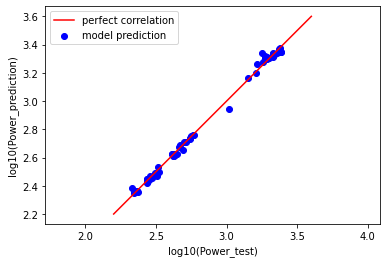

In [26]:
# Build a model scatterplot
_ = plt.scatter(y_test, y_pred_rfr, color ='b', label='model prediction') 



# Add a line for perfect correlation. 

_ = plt.plot([2.2,3.6], [2.2,3.6], color ='r', label='perfect correlation') 

# Label 

_ = plt.xlabel('log10(Power_test)')
_ = plt.ylabel('log10(Power_prediction)') 
_ = plt.axis('equal')
_ = plt.legend()

plt.show()

[0.5800000000000003, 0.9014293307826042]

<Figure size 720x504 with 0 Axes>

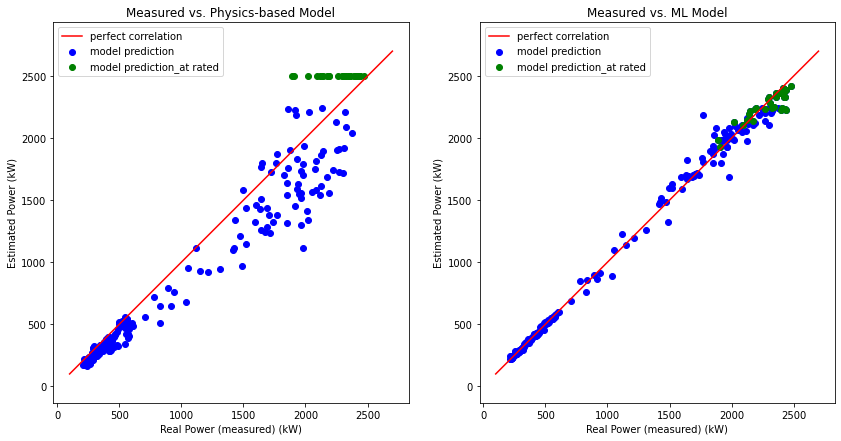

<Figure size 504x504 with 0 Axes>

In [29]:
#Comparing regressor_all model with the physics-based model

def comparer(df,y_pred_ols_all,y): 
    df_test1=df.loc[df['Wind Speed (m/s)']<12 ] #12
    df_test=df_test1.loc[df['Real Power (kW)']<2500 ] #2500
    x_test_array=np.array(df_test[['Wind Speed (m/s)', 'Ambient Temperature (⁰C)', 'Barometric Pressure (mbar)']].values)
    y_test_array=np.array(df_test[['Real Power (kW)']].values)[:,0]
    
    #from eq. 5
    #Note: pressure is multiplied by 100 to convert mbar to Pa
    #Note: 273 is added to temperature to convert C to K
    
    density_estimate=0.0035*(x_test_array[:,2]*100)/(x_test_array[:,1]+273)
    cp_array= np.arange(0.3, 0.59, 0.01)
    P_est=[]
    count=0
    vect_adj_R2=[]
    
    for cp in cp_array:
        #from eq. 1
        #1/1000 factor multiplication to convert W to kW 
        P_line=(1/1000)*1/2*cp*np.array(density_estimate)*7.24e3* (np.array(x_test_array[:,0])**3) 
        P_est.append(P_line)
        count=count+1
        #estimating  adj_R2
        R2=1-((1/len(P_line))*np.sum(np.power((y_test_array-np.array(P_line)),2))/np.var(y_test_array))
        adj_R2=1-((1-R2)*(len(P_line)-1)/(len(P_line)-3-1))
        vect_adj_R2.append(adj_R2)
        
        P_est_np=np.array(P_est)
        
    maxpos = vect_adj_R2.index(max(vect_adj_R2))
    
    
    
    #values at rated
    df_rated=df.loc[df['Wind Speed (m/s)']>=12 ]
    y_test_array_at_rated=np.array(df_rated[['Real Power (kW)']].values)[:,0]
    P_phy_model_optCp_at_rated=2500*np.ones(len(y_test_array_at_rated))
    
    mask=df['Wind Speed (m/s)']>=12
    y_rated=y.loc[mask]
    y_pred_ols_all_rated=y_pred_ols_all[mask]
    #code above for values at rated
        
    P_phy_model_optCp=(1/1000)*1/2*cp_array[maxpos]*np.array(density_estimate)*7.24e3*(np.array(x_test_array[:,0])**3)
    P_phy_model_optCp[P_phy_model_optCp>2500]=2500
    
    plt.figure(figsize=(10,7))
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(14,7))
    
    ax1.plot([100,2700], [100,2700], color ='r', label='perfect correlation')
    ax1.scatter(y_test_array,P_phy_model_optCp,color ='b')
    ax1.scatter(y_test_array_at_rated,P_phy_model_optCp_at_rated,color ='g')
    
    ax1.set(xlabel='Real Power (measured) (kW)', ylabel='Estimated Power (kW)', title='Measured vs. Physics-based Model')
    ax1.legend(['perfect correlation','model prediction','model prediction_at rated'])
    ax1.axis('equal')
    
    speed_array= np.arange(4, 13, 0.1)
    speed_array=np.append(speed_array, 14)
    P_phy_model=(1/1000)*1/2*cp_array[maxpos]*np.mean(density_estimate)*7.24e3*(speed_array**3) 
    speed_array2= np.arange(12, 16.5, 0.1)
    P_phy_model2=2500*np.ones(len(speed_array2)) 
    
    plt.figure(figsize=(7,7))
    ax2.plot([100,2700], [100,2700], color ='r', label='perfect correlation')
    ax2.scatter(y, y_pred_ols_all, color ='b', label='model prediction')
    ax2.scatter(y_rated, y_pred_ols_all_rated, color ='g', label='model prediction_at rated')
    ax2.set(xlabel='Real Power (measured) (kW)', ylabel='Estimated Power (kW)', title='Measured vs. ML Model')
    ax2.legend(['perfect correlation','model prediction','model prediction_at rated'])
    ax2.axis('equal')
    
    output=[cp_array[maxpos], vect_adj_R2[maxpos]]
    return output

y_pred_RFR_all = regressor.predict(x_scaled_log)

y_pred_RFR_all_alog=10**y_pred_RFR_all# takine antilog to retrive the correct units (kW)
y_alog=10**y_log

comparer(df,y_pred_RFR_all_alog,y_alog)

The prediction improvement is evident in the measured vs. prediction plots. As shown in the left panel, the physics-based model seems to overpredict the power produced in Region II (below rated power), and has worse performance at higher wind speeds (**<font color='blue'> blue dots </font>**). The physics-based model is unable to predict power in Region III (rated power) because the turbine is regulated (**<font color='green'> green dots </font>**). As shown in the right panel, the Random Forest Regressor model is robust enough to predict power even in Region III (**<font color='green'> green dots </font>**). Further, a fitting-based estimate of turbine efficiency $Cp$ was not needed for the regressor model prediction.

In [31]:
# Exploring relative feature importance

feature_names=x_log.columns.values
data_wo=abs(regressor.feature_importances_)
data_wo=np.array(data_wo)
#For retrieving the slope:
coeff_df_wo=pd.DataFrame(data_wo,index=feature_names,columns=['feature_importances'])
coeff_df_wo.sort_values(by=['feature_importances'],ascending=False)

,feature_importances
Wind Speed (m/s),0.356023
Cube Wind Speed (m/s)^3,0.314081
Square Wind Speed (m/s)^2,0.221060
Square Wind Speed 79.1m (m/s)^2,0.026229
Wind Speed 79.1m (m/s),0.023107
Cube Wind Speed 79.1m (m/s)^3,0.019948
Barometric Pressure (mbar),0.009799
Std. Wind Speed 79.1m (m/s),0.009159
TI Wind Speed 79.1m (m/s),0.009137
Low speed,0.004422


The wind speed and its cube and square power are of most importance along with temperature. The physics based model only emphasizes the cube of speed. The additional categorical features that classify the wind speed as 'high' or 'low' are critical for the Random Forest Regressor model.

## Finalize Code

In [32]:
import pickle
s = pickle.dumps(regressor)
from joblib import dump, load
dump(regressor, './models/random_forest_regressor_model_windenergy_allfeatures.joblib') 

['./models/random_forest_regressor_model_windenergy_allfeatures.joblib']

## Finalize Documentation

Documentation includes model performance metrics as well as the hyperparameter values included in the final model.

In [40]:
    
param_names=['random_state','max_depth','min_samples_leaf','min_samples_split','n_estimators']
param_value=np.array([1,7,1,2,200])

coeff_df=pd.DataFrame(param_value,index=param_names,columns=['Hyperparameter Values'])
coeff_df=coeff_df.reset_index().rename(columns={'index': 'Hyperparameter'})

In [41]:
coeff_df['Explained Variance']=[round(explained_variance_score(y_test, y_pred_rfr),4)]+['']*(len(coeff_df)-1)
coeff_df['Root Mean Square Error']=[round((mean_squared_error(y_test, y_pred_rfr)**(1/2)),4)]+['']*(len(coeff_df)-1)
coeff_df

,Hyperparameter,Hyperparameter Values,Explained Variance,Root Mean Square Error
0,random_state,1,0.996,0.0244
1,max_depth,7,,
2,min_samples_leaf,1,,
3,min_samples_split,2,,
4,n_estimators,200,,


In [42]:
coeff_df.to_csv('./models/Random Forest Regressor Model_hyperparameters_performance.csv')

## Fitting Models with Training Data Set for Limited Features

In [55]:
# preparing limited feature data set without upstream tower measurements

colTodrop=['Wind Speed 79.1m (m/s)', 'Wind Direction 79.1m (⁰)',
       'Air Temp 76.7m (⁰C)', 'Relative Humidity 76.7m (%)',
       'Barometric Pressure (mbar)', 'Wind Speed Gradient (m/s)',
       'Wind Direction Gradient (⁰)', 'Virt. Pot. Temp. Gradient ($^\circ C$)',
       'Relative Humidity Gradient (%)', 'Std. Wind Speed 79.1m (m/s)', 'TI Wind Speed 79.1m (m/s)','Square Wind Speed 79.1m (m/s)^2', 'Cube Wind Speed 79.1m (m/s)^3',
       'Inverse Ambient Temperature (1/⁰C)']

#Note: 'Ri_B' has been already dropped

x_log_woUP = x_log.drop(colTodrop, axis =1)


# Standardizing the numerical values

# Scaling features (mean=0 std.=1)
x_scaled_log_woUP=preprocessing.scale(x_log_woUP, axis=0, with_mean=True, with_std=True, copy=True)


# Creating train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_scaled_log_woUP, y_log, test_size=0.25)

# Builiding the regressor model (2c in Step5) using optimized hyperparameters found using Bayesian optimizer. Further a while loop is used since output of this model is not consistent
from sklearn.ensemble import RandomForestRegressor
max_iter=10 
metric=0.0
itera=1
while ((metric <= 0.988) and itera<max_iter):
    regressor_woUP = RandomForestRegressor(random_state=1, max_depth=20,
                                           min_samples_leaf= 1, min_samples_split= 4, n_estimators= 81)
    regressor_woUP.fit(X_train, y_train)
    metric=regressor_woUP.score(X_test, y_test)
    itera=itera+1
    
print('Model R^2: ',round(regressor_woUP.score(X_test, y_test),4))

Model R^2:  0.9915


## Review of results  for data without upstream features

In [56]:
y_pred_rfr_woUP = regressor_woUP.predict(X_test)
print('Model Explained Variance: ',round(explained_variance_score(y_test, y_pred_rfr_woUP),4))

Model Explained Variance:  0.9918


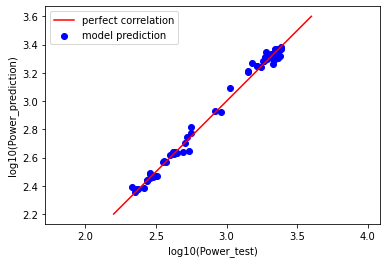

In [57]:
# Build a model scatterplot
_ = plt.scatter(y_test, y_pred_rfr_woUP, color ='b', label='model prediction') 



# Add a line for perfect correlation. 

_ = plt.plot([2.2,3.6], [2.2,3.6], color ='r', label='perfect correlation') 

# Label 

_ = plt.xlabel('log10(Power_test)')
_ = plt.ylabel('log10(Power_prediction)') 
_ = plt.axis('equal')
_ = plt.legend()

plt.show()

[0.5800000000000003, 0.9014293307826042]

<Figure size 720x504 with 0 Axes>

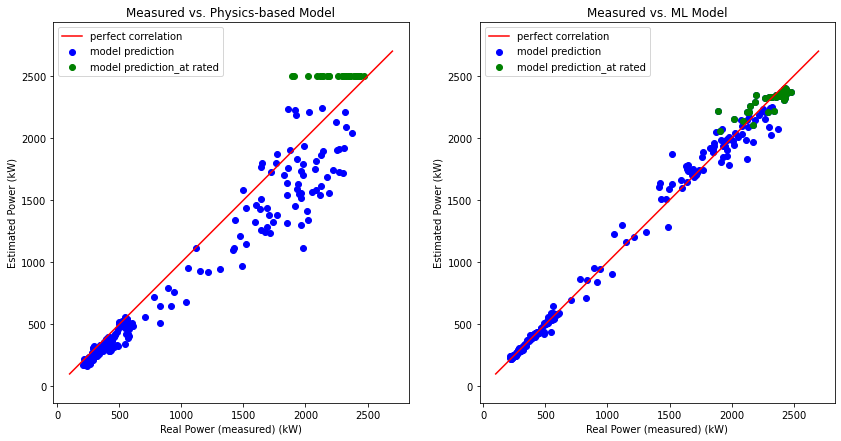

<Figure size 504x504 with 0 Axes>

In [62]:
#Comparison with Physics-based model

y_pred_RFR_woUP = regressor_woUP.predict(x_scaled_log_woUP)

y_pred_RFR_woUP_alog=10**y_pred_RFR_woUP# takine antilog to retrive the correct units (kW)
y_alog=10**y_log

comparer(df,y_pred_RFR_woUP_alog,y_alog)

In [63]:
# Exploring relative feature importance

feature_names_woUP=x_log_woUP.columns.values
data_wo_woUP=abs(regressor_woUP.feature_importances_)
data_wo_woUP=np.array(data_wo_woUP)
#For retrieving the slope:
coeff_df_wo_woUP=pd.DataFrame(data_wo_woUP,index=feature_names_woUP,columns=['feature_importances'])
coeff_df_wo_woUP.sort_values(by=['feature_importances'],ascending=False)

,feature_importances
Square Wind Speed (m/s)^2,0.372158
Wind Speed (m/s),0.313089
Cube Wind Speed (m/s)^3,0.302513
Wind Direction (⁰),0.003706
Inverse Air Temp 76.7m (1/⁰C),0.003090
Ambient Temperature (⁰C),0.002076
Std. Wind Speed (m/s),0.001681
TI Wind Speed,0.001241
Winter,0.000192
High speed,0.000134


The wind speed and its cube and square power are of most importance along with temperature. The physics based model only emphasizes the cube of speed. The additional categorical features that classify the wind speed as 'high' or 'low' are not as critical for the Random Forest Regressor model working on limited feature set.

## Finalize Code for limited feature model

In [65]:
s = pickle.dumps(regressor_woUP)
from joblib import dump, load
dump(regressor_woUP, './models/random_forest_regressor_model_windenergy__woUP.joblib') 

['./models/random_forest_regressor_model_windenergy__woUP.joblib']

## Finalize Documentation for limited feature model

Documentation includes model performance metrics as well as the hyperparameter values included in the final model.

In [68]:
    
param_names=['random_state','max_depth','min_samples_leaf','min_samples_split','n_estimators']
param_value=np.array([1,20,1,4,81])

coeff_df_woUP=pd.DataFrame(param_value,index=param_names,columns=['Hyperparameter Values'])
coeff_df_woUP=coeff_df_woUP.reset_index().rename(columns={'index': 'Hyperparameter'})

coeff_df_woUP['Explained Variance']=[round(explained_variance_score(y_test, y_pred_rfr_woUP),4)]+['']*(len(coeff_df_woUP)-1)
coeff_df_woUP['Root Mean Square Error']=[round((mean_squared_error(y_test, y_pred_rfr_woUP)**(1/2)),4)]+['']*(len(coeff_df_woUP)-1)
coeff_df_woUP

,Hyperparameter,Hyperparameter Values,Explained Variance,Root Mean Square Error
0,random_state,1,0.9918,0.0349
1,max_depth,20,,
2,min_samples_leaf,1,,
3,min_samples_split,4,,
4,n_estimators,81,,


In [69]:
coeff_df_woUP.to_csv('./models/Random Forest Regressor Model_WithoutUspstreamTower_hyperparameters_performance.csv')